# recalculates the raw data and then the anomalies WRT 1999-2010 and removes the trend (calculated over the same period)

**run with:** 
```bash
for i in $(seq 0 7); do 
    stn=${i} runipy process_Rashed_clim.ipynb
done
```

[Nicolas Fauchereau](mailto:nicolas.fauchereau@niwa.co.nz)

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
import pandas as pd
import numpy as np
from dateutil import parser
from datetime import datetime, timedelta
from calendar import monthrange, month_name

### function to go from 2D to 1D and set the datetime index

In [3]:
def make_flat(data): 
    data = data.stack(dropna=False)
    dates = [parser.parse("-".join(map(str, [y, m, 1]))) \
             for y, m in zip(data.index.get_level_values(0), data.index.get_level_values(1))]
    dates = [d + timedelta(monthrange(d.year,d.month)[1]-1) for d in dates]
    data.index = dates
    data = pd.DataFrame(data, columns=['msla'])
    data = data / 10.
    data = data.reindex(pd.date_range(start=data.index[0], end=data.index[-1]+timedelta(28), freq='1M'))
    return data

In [4]:
station_list = ['Guam', 'Yap', 'Pohnpei', 'Majuro', 'Tarawa', 'PagoPago', 'Rarotonga', 'Moturiki']

In [5]:
from os import environ
stn = environ['stn']
station = station_list[int(stn)]

### reads the data for the station

In [6]:
#!open ../../../data/predictands/IWLS_SL_data_op.xlsx

In [7]:
data = pd.read_excel('../../../data/predictands/IWLS_SL_data_op.xlsx', sheetname=station,\
                     parse_cols="B:N", na_values=[9999], header=0)

In [8]:
data.head()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
1980,NaN,NaN,14,-58,-56,-12,15,-52,-11,-34,10,-17
1981,-46,NaN,-31,-6,-45,26,-24,44,-38,-53,-11,-31
1982,-7,-16,-39,41,-32,-38,-33,NaN,-47,56,-62,-67
1983,-81,-111,-103,-34,-24,-41,-75,-77,-23,-43,-35,3
1984,-18,-20,-51,-39,-85,-83,-18,-23,23,1,-55,27


### reads Rashed's climatology

In [9]:
clim = pd.read_excel('../../../data/predictands/IWLS_SL_data_op.xlsx',\
                     sheetname='{}_clim'.format(station), header=0)

In [10]:
clim

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,46,64,66,46,32,7,-10,-30,-41,-30,5,21


### add the clim to the anomalies to get back the `raw` values

In [11]:
raw = pd.DataFrame(data.values + clim.values, index=data.index, columns=data.columns)

In [12]:
raw.head()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
1980,NaN,NaN,80,-12,-24,-5,5,-82,-52,-64,15,4
1981,0,NaN,35,40,-13,33,-34,14,-79,-83,-6,-10
1982,39,48,27,87,0,-31,-43,NaN,-88,26,-57,-46
1983,-35,-47,-37,12,8,-34,-85,-107,-64,-73,-30,24
1984,28,44,15,7,-53,-76,-28,-53,-18,-29,-50,48


### goes 1D

In [13]:
raw = make_flat(raw)

In [14]:
raw.head()

,msla
1980-01-31,NaN
1980-02-29,NaN
1980-03-31,8.0
1980-04-30,-1.2
1980-05-31,-2.4


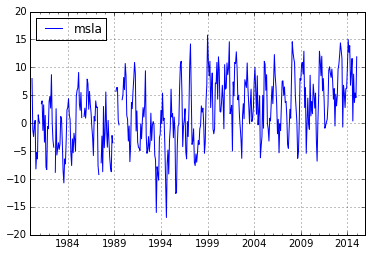

In [15]:
raw.plot()

### make the original data 1D, to insert in the final dataframe

In [16]:
data = make_flat(data)

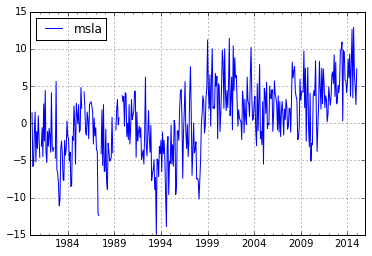

In [17]:
data.plot()

### calculates the climatology

In [18]:
clim = raw.ix['1999':'2010']
clim = clim.groupby(clim.index.month).mean()

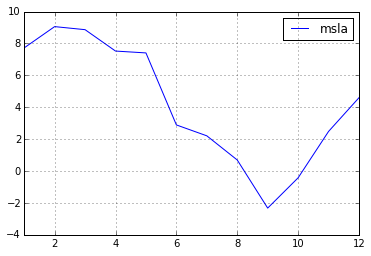

In [19]:
clim.plot()

### now calculates the anomalies WRT to the new clim

In [20]:
def demean(x): 
    z = x - x.ix['1999':'2010'].mean()
    return z

In [21]:
anoms = raw.groupby(raw.index.month).apply(demean)

In [22]:
anoms.head()

,msla
1980-01-31,NaN
1980-02-29,NaN
1980-03-31,-0.866667
1980-04-30,-8.725000
1980-05-31,-9.808333


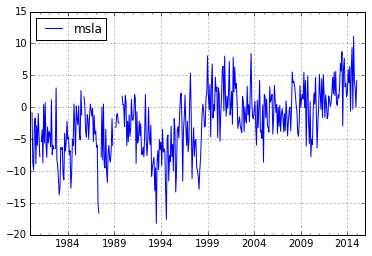

In [23]:
anoms.plot()

### insert the original anomalies for safe-keeping

In [24]:
anoms.loc[:,'msla (orig)'] = data['msla']

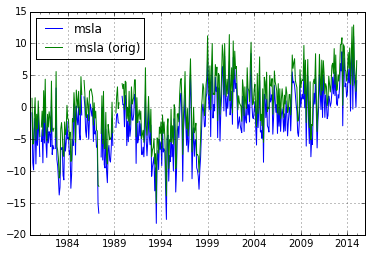

In [25]:
anoms.plot()

### calculate trend over the 1999-2013 period

In [26]:
from scipy.stats import linregress

In [27]:
vals = anoms.loc['1999':'2013','msla'].values
dates = anoms.loc['1999':'2013','msla'].index.to_pydatetime()

In [28]:
start = datetime(1900,1,1)

offset = np.array([((date.year - start.year) * 12 + (date.month - start.month)) for date in dates])

In [29]:
inans = np.where(np.isnan(vals))[0]
ivals = np.where(~np.isnan(vals))[0]

In [30]:
slope, intercept, r, p, std_err = linregress(offset[ivals], vals[ivals])

In [31]:
trend = slope * offset + intercept

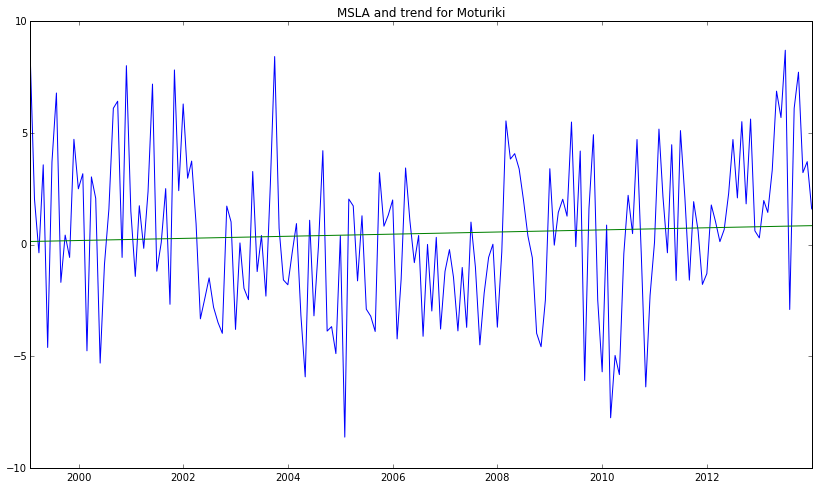

In [32]:
f, ax = plt.subplots(figsize=(14,8))
ax.plot(dates, vals)
ax.plot(dates, trend)
ax.set_title("MSLA and trend for {}".format(station))

### Now remove the trend (1999-2013) over the WHOLE period

In [33]:
dates = anoms.index.to_pydatetime()

In [34]:
offset = np.array([((date.year - start.year) * 12 + (date.month - start.month)) for date in dates])

In [35]:
trend = slope * offset + intercept

In [36]:
anoms.loc[:,'trend'] = trend
anoms.loc[:,'msla (detrend)'] = anoms.msla - anoms.trend

In [37]:
from matplotlib import style
style.use('ggplot')

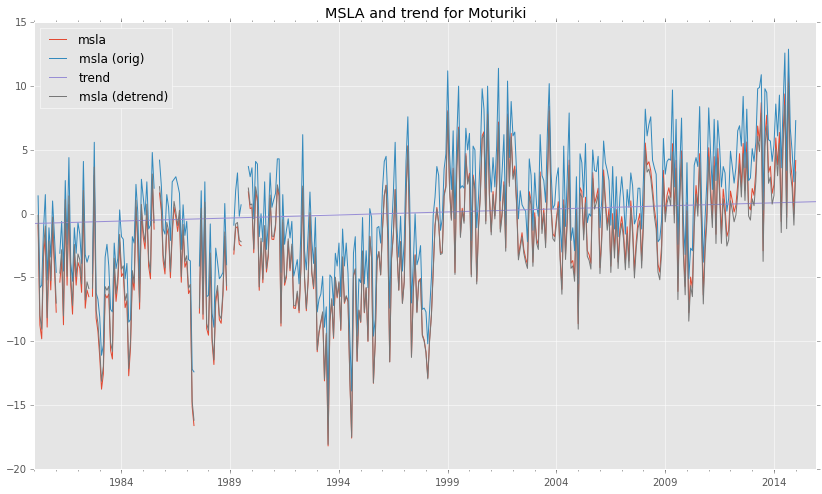

In [38]:
f, ax = plt.subplots(figsize=(14,8))
anoms.plot(ax=ax, title="MSLA and trend for {}".format(station))
ax.set_title("MSLA and trend for {}".format(station))
f.savefig('./MSLA_trend_plot_{}.png'.format(station))

### saves in CSV

In [39]:
anoms.head()

,msla,msla (orig),trend,msla (detrend)
1980-01-31,NaN,NaN,-0.764668,NaN
1980-02-29,NaN,NaN,-0.760703,NaN
1980-03-31,-0.866667,1.4,-0.756738,-0.109929
1980-04-30,-8.725000,-5.8,-0.752772,-7.972228
1980-05-31,-9.808333,-5.6,-0.748807,-9.059526


In [40]:
anoms.to_csv('./{}_1999_2010_clim.csv'.format(station))

### saves into an excel file 

In [41]:
xl_file = pd.ExcelWriter('./{}_1999_2010_clim.xlsx'.format(station))

### data itself

In [42]:
anoms.to_excel(xl_file, sheet_name='data')

## climatology (1999 - 2010)

In [43]:
clim.index = [month_name[m] for m in clim.index]

In [44]:
clim.to_excel(xl_file, sheet_name='climatology (1999-2010)')

## date offset for trend

In [45]:
df = pd.DataFrame(offset, index=dates, columns=['date offset since 1900-01-01 (months)'])

In [46]:
df.to_excel(xl_file, sheet_name='date offset')

### slope and intercept of 1999-2013 trend

In [47]:
d = {}
d['slope'] = slope
d['intercept'] = intercept

In [48]:
df = pd.DataFrame(d, index=['trend parameters (1999-2013)'])

In [49]:
df.to_excel(xl_file, sheet_name='trend parameters')

In [50]:
xl_file.save()